Copyright (c) 2024 Microsoft Corporation.

Licensed under the MIT License

Experimenting with `xBD` dataset under 5 settings:
- Same Type Far: nepal_flood_post_midwest_flood_post
- Same Type Close: santa-rosa-wildfire-post_woolsey-fire-pos
- Different Type Far: hurricane-matthew_post_nepal_flood_post
- Different Type Close: hurricane-matthew_mexico-earthquake
- Pre Post: portugal-wildfire-pre-post

For each, we perform: 
- layer benchmarking
- activation extraction
- `g` training and evaluation
- `g_hat` training and evaluation
- `g` and `g_hat` statistical significance test
- `g` benchmark
- clustering benchmark
- num_cluster vs. `g` and `g_hat` performance investigation
- activation space visualization    


In [1]:
import os
import sys

import torch

sys.path.append("..")
from src.tardis.eurosat_xbd_utils import *
from src.tardis.utils import *

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(0))

%load_ext autoreload
%autoreload 2

fixed_seed = 31
set_seed(fixed_seed)

CUDA available: True
Number of GPUs: 2
Current GPU: 0
GPU Name: NVIDIA A100 80GB PCIe


In [2]:
# Define main directories for checkpoints and configs
ckpt_main_dir = "/data/dataood/exp_data/main_tardis/xbd_exp_logs"
config_main_dir = "/ws/geospatial-ood-detection/configs/xbd/"

# Configuration paths
same_far_config_path = f"{config_main_dir}xbd_config_samedisaster_distant.yaml"
same_close_config_path = f"{config_main_dir}xbd_config_samedisaster_close.yaml"
different_far_config_path = f"{config_main_dir}xbd_config_differentdisaster_distant.yaml"
different_close_config_path = f"{config_main_dir}xbd_config_differentdisaster_close.yaml"
pre_post_config_path = f"{config_main_dir}xbd_config_prepost.yaml"

# Parameters
collect_activations_from_layers = ["encoder.layer2.0.conv1"]
getitem_keys = ["image", "mask"]
n_batches_to_process = 2 # Set to ´None´ to process all the samples
downsample_method = "max_pool"
verbose = False
device = "cuda" if torch.cuda.is_available() else "cpu"

# Downsample methods
downsample_methods = ["avg_pool", "mean_std", "avg_pool", "max_pool", "nodownsample"]
downsample_benchmark = {}

# Benchmark settings
test_size = 0.2
n_estimators = 100
split_seed = 31
fixed_classifier_seed = 31
layer_benchmark = {}

# Optuna settings
n_optuna_trials = 20
min_cluster = 2
max_cluster_ratio = 0.3
min_fraction = 0.01
max_fraction = 0.2
fixed_seed = 31

# Different type - Close

In [3]:
model, cfg = get_model_config(different_close_config_path, ckpt_main_dir, device)
datamodule, datamodule_train, datamodule_val, datamodule_test = prepare_datamodule(cfg)

Reading experiment from:  /data/dataood/exp_data/main_tardis/xbd_exp_logs/xview2_hurricane-matthew_mexico-earthquake_01/test_eval_results_xview2_hurricane-matthew_mexico-earthquake_01.json


/opt/conda/envs/ood/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpr4ih0_gb
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpr4ih0_gb/_remote_module_non_scriptable.py


Exp Results:
 {'test_results': [{'test_loss': 0.5736727118492126, 'test_MulticlassAccuracy': 0.7332066297531128, 'test_MulticlassJaccardIndex': 0.578789472579956}], 'best_model_path': '/data/dataood/exp_data/main_tardis/xbd_exp_logs/xview2_hurricane-matthew_mexico-earthquake_01/epoch=5-step=36.ckpt'}
Model loaded and set to evaluation mode.
Root /data/dataood/xview2/
Loaded for disasters ID and OOD: 405 train, 193 test files.
Loaded for disasters ID and OOD: 405 train, 193 test files.


### Downsample Benchmark

In [4]:
nametag = (
    cfg.id_ood_disaster[0]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[0]["pre-post"]
    + "_"
    + cfg.id_ood_disaster[1]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[1]["pre-post"]
)

for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=datamodule_train,
        test_dataloader=datamodule_test,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    downsample_benchmark[downsample] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:08<00:00,  4.36s/it]


Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)


100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)


100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)
Run g experiment for downsample method: nodownsample


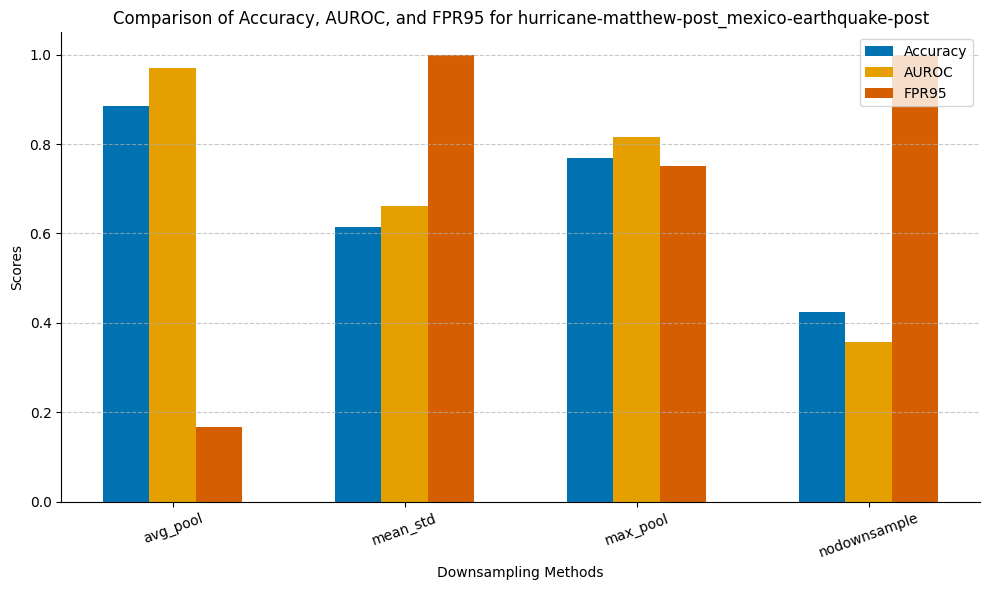

In [5]:
plot_downsample_benchmark(downsample_benchmark, nametag)

### Layer Benchmark

In [6]:
all_layer_names = get_all_layer_names(model)
selected_layers = pick_random_layers(all_layer_names, 10)
selected_layers = [[layer] for layer in selected_layers]
print("Selected 10 layers:", selected_layers)

Selected 10 layers: [['encoder.conv1'], ['encoder.layer1.0.conv2'], ['decoder.blocks.1.conv2'], ['encoder.layer2.1.conv3'], ['decoder.blocks.0.conv1.1'], ['encoder.layer2.3.conv1'], ['encoder.layer1.1.conv3'], ['encoder.layer2.2.conv3'], ['decoder.blocks.2.conv2'], ['decoder.blocks.4.conv2.2']]


In [7]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=datamodule_train,
        test_dataloader=datamodule_test,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )

    layer_benchmark[str(lyr)] = g_benchmark

Running experiments for layer ['encoder.conv1']


100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


Before downsampling, activations shape for layer encoder.conv1 : (64, 64, 128, 128)


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Before downsampling, activations shape for layer encoder.conv1 : (64, 64, 128, 128)
Running experiments for layer ['encoder.layer1.0.conv2']


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Before downsampling, activations shape for layer encoder.layer1.0.conv2 : (64, 64, 64, 64)


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Before downsampling, activations shape for layer encoder.layer1.0.conv2 : (64, 64, 64, 64)
Running experiments for layer ['decoder.blocks.1.conv2']


100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


Before downsampling, activations shape for layer decoder.blocks.1.conv2 : (64, 128, 32, 32)


100%|██████████| 2/2 [00:07<00:00,  3.65s/it]


Before downsampling, activations shape for layer decoder.blocks.1.conv2 : (64, 128, 32, 32)
Running experiments for layer ['encoder.layer2.1.conv3']


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


Before downsampling, activations shape for layer encoder.layer2.1.conv3 : (64, 512, 32, 32)


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Before downsampling, activations shape for layer encoder.layer2.1.conv3 : (64, 512, 32, 32)
Running experiments for layer ['decoder.blocks.0.conv1.1']


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


Before downsampling, activations shape for layer decoder.blocks.0.conv1.1 : (64, 256, 16, 16)


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


Before downsampling, activations shape for layer decoder.blocks.0.conv1.1 : (64, 256, 16, 16)
Running experiments for layer ['encoder.layer2.3.conv1']


100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


Before downsampling, activations shape for layer encoder.layer2.3.conv1 : (64, 128, 32, 32)


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Before downsampling, activations shape for layer encoder.layer2.3.conv1 : (64, 128, 32, 32)
Running experiments for layer ['encoder.layer1.1.conv3']


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


Before downsampling, activations shape for layer encoder.layer1.1.conv3 : (64, 256, 64, 64)


100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


Before downsampling, activations shape for layer encoder.layer1.1.conv3 : (64, 256, 64, 64)
Running experiments for layer ['encoder.layer2.2.conv3']


100%|██████████| 2/2 [00:03<00:00,  1.93s/it]


Before downsampling, activations shape for layer encoder.layer2.2.conv3 : (64, 512, 32, 32)


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Before downsampling, activations shape for layer encoder.layer2.2.conv3 : (64, 512, 32, 32)
Running experiments for layer ['decoder.blocks.2.conv2']


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Before downsampling, activations shape for layer decoder.blocks.2.conv2 : (64, 64, 64, 64)


100%|██████████| 2/2 [00:04<00:00,  2.37s/it]


Before downsampling, activations shape for layer decoder.blocks.2.conv2 : (64, 64, 64, 64)
Running experiments for layer ['decoder.blocks.4.conv2.2']


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


Before downsampling, activations shape for layer decoder.blocks.4.conv2.2 : (64, 16, 256, 256)


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Before downsampling, activations shape for layer decoder.blocks.4.conv2.2 : (64, 16, 256, 256)


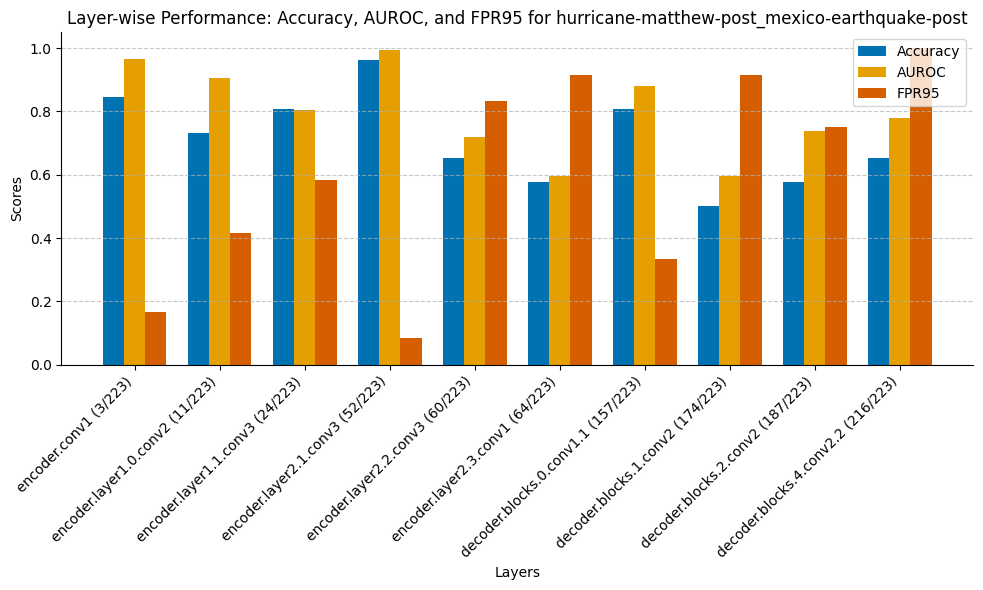

In [8]:
plot_layer_benchmark(layer_benchmark, all_layer_names, nametag)

### Property extraction

In [9]:
all_layer_names = get_all_layer_names(model)

In [10]:
collect_activations_from_layers = ["encoder.layer2.0.conv1"]
device = "cuda" if torch.cuda.is_available() else "cpu"
getitem_keys = ["image", "mask"]
n_batches_to_process = n_batches_to_process
downsample_method = "avg_pool"
verbose = False

X, y, test_property_lengths = create_feature_matrix_and_labels(
    model=model,
    dm=datamodule,
    train_dataloader=datamodule_train,
    test_dataloader=datamodule_test,
    layer_names=collect_activations_from_layers,
    device=device,
    getitem_keys=getitem_keys,
    n_batches_to_process=n_batches_to_process,
    downsample_method=downsample_method,
    verbose=verbose,
)

100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]

Before downsampling, activations shape for layer encoder.layer2.0.conv1 : (64, 128, 64, 64)


### g confidence interval

In [11]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 7365
random_state for split_seed: 7093
random_state for split_seed: 2945
random_state for split_seed: 7567
random_state for split_seed: 5159
random_state for split_seed: 6818
random_state for split_seed: 4403
random_state for split_seed: 2368
random_state for split_seed: 4349
random_state for split_seed: 2873


In [12]:
# Calculate confidence intervals for the specified columns
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.9038461538461539, 0.04152456599327423),
 'baseline_fpr95': (0.1266198507374978, 0.0815018742842373),
 'baseline_roc_auc': (0.9576640252658353, 0.01735911762795821)}

### g_hat

In [13]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 19:57:49,534] A new study created in memory with name: no-name-7e98950f-5a9d-47de-8f6f-df52908f5b73
[I 2024-12-22 19:57:49,614] Trial 0 finished with value: -0.6760916628535989 and parameters: {'k': 10, 'M': 0.19204005763861}. Best is trial 0 with value: -0.6760916628535989.
[I 2024-12-22 19:57:49,638] Trial 1 finished with value: -0.8053261627177224 and parameters: {'k': 24, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.8053261627177224.
[I 2024-12-22 19:57:49,642] Trial 2 finished with value: inf and parameters: {'k': 8, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.8053261627177224.
[I 2024-12-22 19:57:49,667] Trial 3 finished with value: -0.8558693597685767 and parameters: {'k': 28, 'M': 0.023041318415652854}. Best is trial 3 with value: -0.8558693597685767.
[I 2024-12-22 19:57:49,671] Trial 4 finished with value: inf and parameters: {'k': 4, 'M': 0.11327159100258942}. Best is trial 3 with value: -0.8558693597685767.
[I 2024-12-22 19:57:49,675]

In [14]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 38 0.023041318415652854 128 0.296875
random_state for split_seed in iteration 1: 6488
random_state for split_seed in iteration 2: 4865
random_state for split_seed in iteration 3: 5640
random_state for split_seed in iteration 4: 9922
random_state for split_seed in iteration 5: 2232
random_state for split_seed in iteration 6: 766
random_state for split_seed in iteration 7: 2456
random_state for split_seed in iteration 8: 2898
random_state for split_seed in iteration 9: 5930
random_state for split_seed in iteration 10: 4576


### g g_hat mean std + ttest

In [15]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.9038461538461539, Std Dev = 0.058047340629086015
Baseline ROC AUC: Mean = 0.9576640252658353, Std Dev = 0.024266373166517183
Baseline FPR95: Mean = 0.1266198507374978, Std Dev = 0.11393176413336499
g_hat Accuracy: Mean = 0.773076923076923, Std Dev = 0.08199116387343323
g_hat ROC AUC: Mean = 0.9087219884816038, Std Dev = 0.09033870883821105
g_hat FPR95: Mean = 0.2726486013986014, Std Dev = 0.18989441278885447
Accuracy: t = 4.116384992583438, p = 0.0006481597473076909
ROC AUC: t = 1.6545485750917301, p = 0.11534792236355944
FPR95: t = -2.085266930829503, p = 0.05155526559775302


{'accuracy': (4.116384992583438, 0.0006481597473076909),
 'roc_auc': (1.6545485750917301, 0.11534792236355944),
 'fpr95': (-2.085266930829503, 0.05155526559775302)}

### Benchmark g

In [16]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [17]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

,Clustering,Accuracy,ROC_AUC,FPR95,Clustering Time (s),Classifier Training Time (s),Number of Samples
0,KMeans,0.5,0.5,1.0,0.003211,0.089548,102
1,DBSCAN_eps_0.1,0.5,0.5,1.0,0.004029,0.091775,102
2,DBSCAN_eps_0.2,0.5,0.5,1.0,0.003774,0.093642,102
3,DBSCAN_eps_0.5,0.5,0.5,1.0,0.003755,0.093542,102


### Investigate k wrt g-g_hat

confidence_intervals_g {'baseline_accuracy': (0.9038461538461539, 0.04152456599327423), 'baseline_fpr95': (0.1266198507374978, 0.0815018742842373), 'baseline_roc_auc': (0.9576640252658353, 0.01735911762795821)}
Max i: 6
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
Skipping k=2 on run 1 due to single class in y_clusters.
Skipping k=2 on run 2 due to single class in y_clusters.
Skipping k=2 on run 3 due to single class in y_clusters.
Skipping k=2 on run 4 due to

/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")


Skipping k=2 on run 8 due to single class in y_clusters.
Skipping k=2 on run 9 due to single class in y_clusters.
Skipping k=2 on run 10 due to single class in y_clusters.
k: 4
Skipping k=4 on run 1 due to single class in y_clusters.
Skipping k=4 on run 2 due to single class in y_clusters.
Skipping k=4 on run 3 due to single class in y_clusters.
Skipping k=4 on run 4 due to single class in y_clusters.
Skipping k=4 on run 5 due to single class in y_clusters.
Skipping k=4 on run 6 due to single class in y_clusters.
Skipping k=4 on run 7 due to single class in y_clusters.
Skipping k=4 on run 8 due to single class in y_clusters.
Skipping k=4 on run 9 due to single class in y_clusters.
Skipping k=4 on run 10 due to single class in y_clusters.
k: 8
Skipping k=8 on run 1 due to single class in y_clusters.
Skipping k=8 on run 4 due to single class in y_clusters.
Skipping k=8 on run 5 due to single class in y_clusters.
Skipping k=8 on run 8 due to single class in y_clusters.
Skipping k=8 on run

/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")


k: 32
k: 64
k: 102


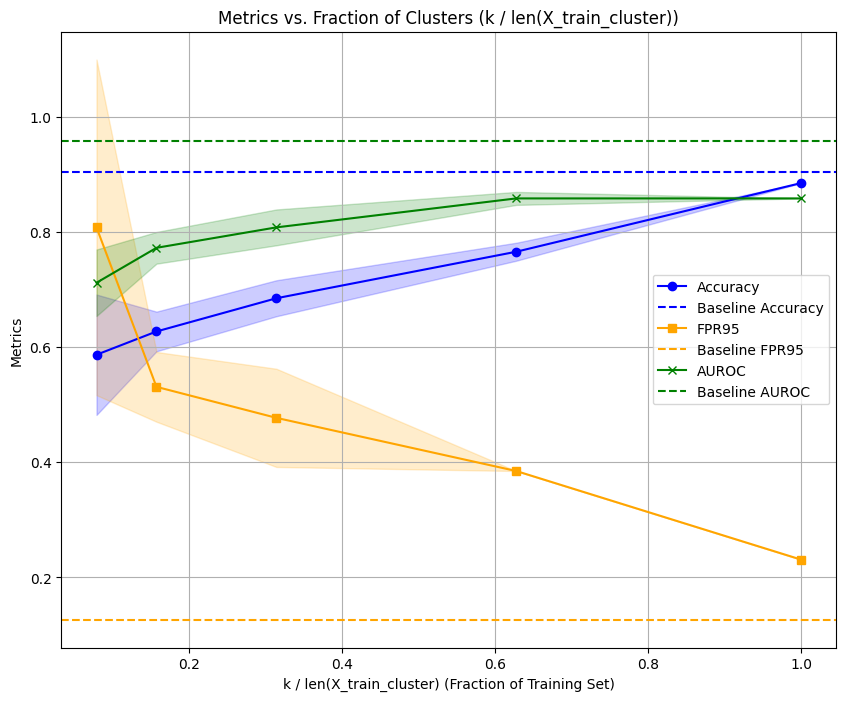

In [18]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Proportion of label changes: 0.17


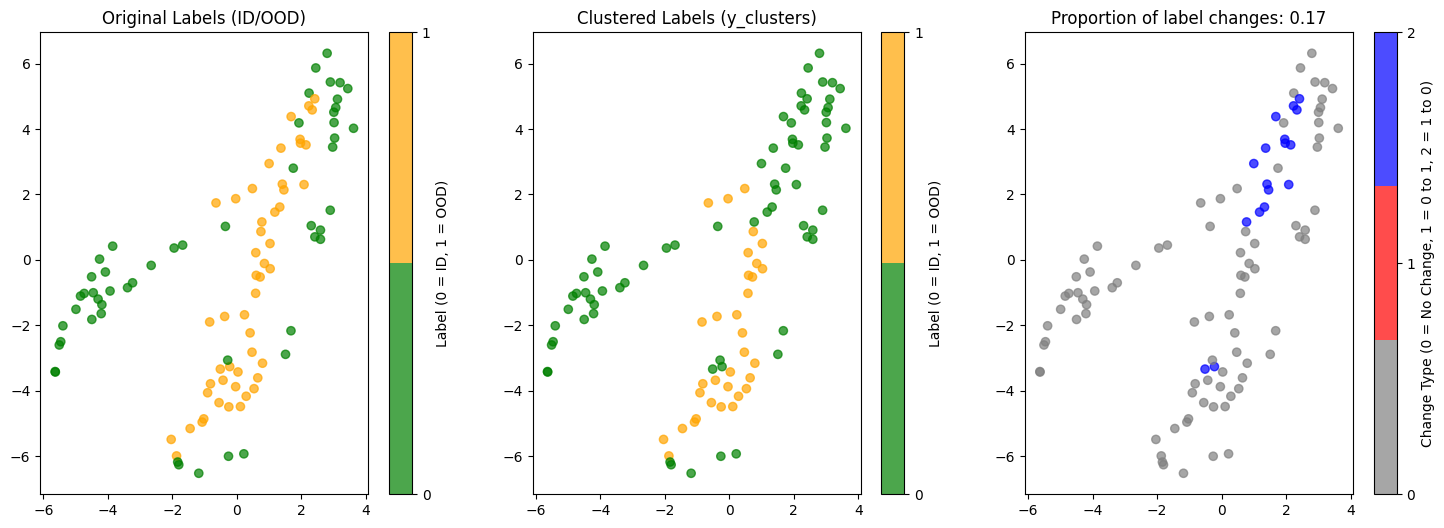

In [19]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i
)
plot_tsne_with_label_changes(
    X_train_cluster, y_train_cluster, y_clusters, class_name="Disaster"
)

# Same type - Far

In [ ]:
model, cfg = get_model_config(same_far_config_path, ckpt_main_dir, device)
datamodule, datamodule_train, datamodule_val, datamodule_test = prepare_datamodule(cfg)

### Downsample Benchmark

In [ ]:
nametag = (
    cfg.id_ood_disaster[0]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[0]["pre-post"]
    + "_"
    + cfg.id_ood_disaster[1]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[1]["pre-post"]
)

for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=datamodule_train,
        test_dataloader=datamodule_test,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, nametag)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=datamodule_train,
        test_dataloader=datamodule_test,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, nametag)

### Property extraction

In [ ]:
X, y, test_property_lengths = create_feature_matrix_and_labels(
    model=model,
    dm=datamodule,
    train_dataloader=datamodule_train,
    test_dataloader=datamodule_test,
    layer_names=collect_activations_from_layers,
    device=device,
    getitem_keys=getitem_keys,
    n_batches_to_process=n_batches_to_process,
    downsample_method=downsample_method,
    verbose=verbose,
)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
# Calculate confidence intervals for the specified columns
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
nametag = (
    cfg.id_ood_disaster[0]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[0]["pre-post"]
    + "_"
    + cfg.id_ood_disaster[1]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[1]["pre-post"]
)

print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=nametag,
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i
)
plot_tsne_with_label_changes(
    X_train_cluster, y_train_cluster, y_clusters, class_name="Disaster"
)

# Same type - Close

In [ ]:
model, cfg = get_model_config(same_close_config_path, ckpt_main_dir, device)
datamodule, datamodule_train, datamodule_val, datamodule_test = prepare_datamodule(cfg)

### Downsample Benchmark

In [ ]:
nametag = (
    cfg.id_ood_disaster[0]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[0]["pre-post"]
    + "_"
    + cfg.id_ood_disaster[1]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[1]["pre-post"]
)

for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=datamodule_train,
        test_dataloader=datamodule_test,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, nametag)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=datamodule_train,
        test_dataloader=datamodule_test,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, nametag)

### Property extraction

In [ ]:
all_layer_names = get_all_layer_names(model)

In [ ]:
collect_activations_from_layers = ["encoder.layer2.0.conv1"]
device = "cuda" if torch.cuda.is_available() else "cpu"
getitem_keys = ["image", "mask"]
n_batches_to_process = n_batches_to_process
downsample_method = "avg_pool"
verbose = False

X, y, test_property_lengths = create_feature_matrix_and_labels(
    model=model,
    dm=datamodule,
    train_dataloader=datamodule_train,
    test_dataloader=datamodule_test,
    layer_names=collect_activations_from_layers,
    device=device,
    getitem_keys=getitem_keys,
    n_batches_to_process=n_batches_to_process,
    downsample_method=downsample_method,
    verbose=verbose,
)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
# Calculate confidence intervals for the specified columns
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i
)
plot_tsne_with_label_changes(
    X_train_cluster, y_train_cluster, y_clusters, class_name="Disaster"
)

# Different type - Far

In [ ]:
model, cfg = get_model_config(different_far_config_path, ckpt_main_dir, device)
datamodule, datamodule_train, datamodule_val, datamodule_test = prepare_datamodule(cfg)

### Downsample Benchmark

In [ ]:
nametag = (
    cfg.id_ood_disaster[0]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[0]["pre-post"]
    + "_"
    + cfg.id_ood_disaster[1]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[1]["pre-post"]
)

for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=datamodule_train,
        test_dataloader=datamodule_test,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, nametag)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=datamodule_train,
        test_dataloader=datamodule_test,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, nametag)

### Property extraction

In [ ]:
all_layer_names = get_all_layer_names(model)

In [ ]:
collect_activations_from_layers = ["encoder.layer2.0.conv1"]
device = "cuda" if torch.cuda.is_available() else "cpu"
getitem_keys = ["image", "mask"]
n_batches_to_process = n_batches_to_process
downsample_method = "avg_pool"
verbose = False

X, y, test_property_lengths = create_feature_matrix_and_labels(
    model=model,
    dm=datamodule,
    train_dataloader=datamodule_train,
    test_dataloader=datamodule_test,
    layer_names=collect_activations_from_layers,
    device=device,
    getitem_keys=getitem_keys,
    n_batches_to_process=n_batches_to_process,
    downsample_method=downsample_method,
    verbose=verbose,
)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
# Calculate confidence intervals for the specified columns
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
nametag = (
    cfg.id_ood_disaster[0]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[0]["pre-post"]
    + "_"
    + cfg.id_ood_disaster[1]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[1]["pre-post"]
)

print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    fname=nametag,
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i
)
plot_tsne_with_label_changes(
    X_train_cluster, y_train_cluster, y_clusters, class_name="Disaster"
)

# Pre Post

In [ ]:
model, cfg = get_model_config(pre_post_config_path, ckpt_main_dir, device)
datamodule, datamodule_train, datamodule_val, datamodule_test = prepare_datamodule(cfg)

### Downsample Benchmark

In [ ]:
nametag = (
    cfg.id_ood_disaster[0]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[0]["pre-post"]
    + "_"
    + cfg.id_ood_disaster[1]["disaster_name"]
    + "-"
    + cfg.id_ood_disaster[1]["pre-post"]
)

for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=datamodule_train,
        test_dataloader=datamodule_test,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, nametag)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=datamodule_train,
        test_dataloader=datamodule_test,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, nametag)

### Property extraction

In [ ]:
all_layer_names = get_all_layer_names(model)

In [ ]:
collect_activations_from_layers = ["encoder.layer2.0.conv1"]
device = "cuda" if torch.cuda.is_available() else "cpu"
getitem_keys = ["image", "mask"]
n_batches_to_process = n_batches_to_process
downsample_method = "avg_pool"
verbose = False

X, y, test_property_lengths = create_feature_matrix_and_labels(
    model=model,
    dm=datamodule,
    train_dataloader=datamodule_train,
    test_dataloader=datamodule_test,
    layer_names=collect_activations_from_layers,
    device=device,
    getitem_keys=getitem_keys,
    n_batches_to_process=n_batches_to_process,
    downsample_method=downsample_method,
    verbose=verbose,
)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
# Calculate confidence intervals for the specified columns
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i
)
plot_tsne_with_label_changes(
    X_train_cluster, y_train_cluster, y_clusters, class_name="Disaster"
)